In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Concatenate
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from tensorflow.keras.regularizers import l2


output = pd.read_csv("Matrix_R_T5.dat", sep='\s+')
data_in1 = pd.read_csv("matrix_SiO2.txt", sep='\s+')
data_in2 = pd.read_csv("matrix_ZnS.txt", sep='\s+')

output = output.to_numpy()

data_in1 = data_in1.to_numpy()
data_in2 = data_in2.to_numpy()

data_in2 = data_in2[:, 1:]  # Eliminamos la primera columna repetida

# Dividir la entrada en longitud de onda y índices de refracción
x_train_wavelength = data_in1[:, 0].reshape(-1, 1)  # Primera columna: longitud de onda
x_train_refractive = np.concatenate((data_in1[:, 1:], data_in2[:, :]), axis=1)  # Índices de refracción


x_train, x_temp, y_train, y_temp = train_test_split(np.concatenate((x_train_wavelength, x_train_refractive), axis=1), output, test_size=0.2, random_state=80)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=80)

y_valid = y_valid[:, 1:]

# Reorganizar los datos para la red neuronal
x_train_wavelength = x_train[:, 0].reshape(-1, 1)
x_train_refractive = x_train[:, 1:].reshape(x_train.shape[0], 2, 2)  # Dos pasos de tiempo, dos características
x_valid_wavelength = x_valid[:, 0].reshape(-1, 1)
x_valid_refractive = x_valid[:, 1:].reshape(x_valid.shape[0], 2, 2)
x_test_wavelength = x_test[:, 0].reshape(-1, 1)
x_test_refractive = x_test[:, 1:].reshape(x_test.shape[0], 2, 2)




y_train = y_train[:, 1:]

y_test = y_test[:, 1:]


In [2]:
class CustomModel(Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_wavelength = Dense(2, activation='relu', kernel_regularizer=l2(0))
        self.rnn_refractive = SimpleRNN(66, activation='relu', kernel_regularizer=l2(0))
        self.dense_concat = Dense(226, activation='relu', kernel_regularizer=l2(0))
        self.dense_output = Dense(4, kernel_regularizer=l2(0))

    def call(self, inputs):
        input_wavelength, input_refractive = inputs
        x_wavelength = self.dense_wavelength(input_wavelength)
        x_refractive = self.rnn_refractive(input_refractive)
        x_concat = Concatenate()([x_wavelength, x_refractive])
        x = self.dense_concat(x_concat)
        return self.dense_output(x)

# Crear y compilar el modelo
model = CustomModel()
model.compile(optimizer='adam', loss='mean_squared_error')

r2_test_values = []
loss_values= []
validation_values=[]

for epoch in range(400):
    history = model.fit([x_train_wavelength, x_train_refractive], y_train, validation_data=([x_valid_wavelength, x_valid_refractive], y_valid), verbose=False)
    loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    y_pred_test = model.predict([x_test_wavelength, x_test_refractive])
    r2_test = r2_score(y_test, y_pred_test)
    r2_test_values.append(r2_test)
    loss_values.append(loss)
    validation_values.append(val_loss)
    print(f'Epoch {epoch + 1}, MSE: {loss}, VALIDATION MSE: {val_loss}, Test R²: {r2_test}')

12/12 [==============================] - 0s 3ms/step
Epoch 1, MSE: 198.6881561279297, VALIDATION MSE: 2.6365292072296143, Test R²: -201.83987370233731
12/12 [==============================] - 0s 3ms/step
Epoch 2, MSE: 1.1046864986419678, VALIDATION MSE: 0.1169671043753624, Test R²: -5.9382877396359035
12/12 [==============================] - 0s 4ms/step
Epoch 3, MSE: 0.05385877937078476, VALIDATION MSE: 0.0376727432012558, Test R²: -0.9275045891247612
12/12 [==============================] - 0s 3ms/step
Epoch 4, MSE: 0.03486789017915726, VALIDATION MSE: 0.031074970960617065, Test R²: -0.6193134797957187
12/12 [==============================] - 0s 3ms/step
Epoch 5, MSE: 0.030133508145809174, VALIDATION MSE: 0.0277783814817667, Test R²: -0.4949689916615961
12/12 [==============================] - 0s 2ms/step
Epoch 6, MSE: 0.024627698585391045, VALIDATION MSE: 0.02235213853418827, Test R²: -0.24755268944356154
12/12 [==============================] - 0s 3ms/step
Epoch 7, MSE: 0.0215756408

12/12 [==============================] - 0s 3ms/step
Epoch 54, MSE: 0.013048210181295872, VALIDATION MSE: 0.07577205449342728, Test R²: -3.1432161634834737
12/12 [==============================] - 0s 3ms/step
Epoch 55, MSE: 0.2718062698841095, VALIDATION MSE: 0.04285109415650368, Test R²: -8.61386248093246
12/12 [==============================] - 0s 4ms/step
Epoch 56, MSE: 0.03635774552822113, VALIDATION MSE: 0.007653356064110994, Test R²: 0.499793017727602
12/12 [==============================] - 0s 3ms/step
Epoch 57, MSE: 0.009377342648804188, VALIDATION MSE: 0.009924360550940037, Test R²: 0.3730214670811436
12/12 [==============================] - 0s 3ms/step
Epoch 58, MSE: 0.014155802316963673, VALIDATION MSE: 0.020475268363952637, Test R²: -1.2531894170973974
12/12 [==============================] - 0s 3ms/step
Epoch 59, MSE: 0.023487284779548645, VALIDATION MSE: 0.009315096773207188, Test R²: -0.35903217093713025
12/12 [==============================] - 0s 3ms/step
Epoch 60, MSE:

12/12 [==============================] - 0s 3ms/step
Epoch 107, MSE: 0.07790400087833405, VALIDATION MSE: 0.05647726729512215, Test R²: -12.462154559030603
12/12 [==============================] - 0s 4ms/step
Epoch 108, MSE: 0.03627286106348038, VALIDATION MSE: 0.008189944550395012, Test R²: -0.23098943252081244
12/12 [==============================] - 0s 2ms/step
Epoch 109, MSE: 0.022360557690262794, VALIDATION MSE: 0.029480423778295517, Test R²: -1.5374386323012041
12/12 [==============================] - 0s 4ms/step
Epoch 110, MSE: 0.06700558215379715, VALIDATION MSE: 0.17658352851867676, Test R²: -18.274704854298328
12/12 [==============================] - 0s 3ms/step
Epoch 111, MSE: 0.08771811425685883, VALIDATION MSE: 0.02790604718029499, Test R²: -0.7088117816221183
12/12 [==============================] - 0s 4ms/step
Epoch 112, MSE: 0.06815940141677856, VALIDATION MSE: 0.20268727838993073, Test R²: -57.274914147475315
12/12 [==============================] - 0s 4ms/step
Epoch 1

12/12 [==============================] - 0s 3ms/step
Epoch 160, MSE: 0.02960897423326969, VALIDATION MSE: 0.01668618991971016, Test R²: 0.08911223338460958
12/12 [==============================] - 0s 4ms/step
Epoch 161, MSE: 0.1404760330915451, VALIDATION MSE: 0.20854583382606506, Test R²: -56.134558361184794
12/12 [==============================] - 0s 3ms/step
Epoch 162, MSE: 0.15213492512702942, VALIDATION MSE: 0.25129014253616333, Test R²: -40.030322649362915
12/12 [==============================] - 0s 3ms/step
Epoch 163, MSE: 0.05379480868577957, VALIDATION MSE: 0.016180314123630524, Test R²: 0.17851673123635095
12/12 [==============================] - 0s 3ms/step
Epoch 164, MSE: 0.034675613045692444, VALIDATION MSE: 0.16934938728809357, Test R²: -64.18245396749846
12/12 [==============================] - 0s 4ms/step
Epoch 165, MSE: 0.356342613697052, VALIDATION MSE: 0.06567694246768951, Test R²: -9.686526311673546
12/12 [==============================] - 0s 4ms/step
Epoch 166, MSE

12/12 [==============================] - 0s 4ms/step
Epoch 213, MSE: 0.12862107157707214, VALIDATION MSE: 0.05861874297261238, Test R²: -2.3397093720023334
12/12 [==============================] - 0s 2ms/step
Epoch 214, MSE: 0.03309254348278046, VALIDATION MSE: 0.06201866641640663, Test R²: -1.763844261054591
12/12 [==============================] - 0s 4ms/step
Epoch 215, MSE: 0.017620379105210304, VALIDATION MSE: 0.0075050704181194305, Test R²: 0.5617384887482519
12/12 [==============================] - 0s 4ms/step
Epoch 216, MSE: 0.023229531943798065, VALIDATION MSE: 0.08837254345417023, Test R²: -3.2888100036607977
12/12 [==============================] - 0s 4ms/step
Epoch 217, MSE: 0.033247847110033035, VALIDATION MSE: 0.005744584370404482, Test R²: 0.5961197887876688
12/12 [==============================] - 0s 4ms/step
Epoch 218, MSE: 0.013097609393298626, VALIDATION MSE: 0.022076765075325966, Test R²: -0.8018905537966541
12/12 [==============================] - 0s 4ms/step
Epoch 

12/12 [==============================] - 0s 3ms/step
Epoch 317, MSE: 0.005902410484850407, VALIDATION MSE: 0.0035065277479588985, Test R²: 0.7551493960357194
12/12 [==============================] - 0s 3ms/step
Epoch 318, MSE: 0.004783500451594591, VALIDATION MSE: 0.0067063188180327415, Test R²: 0.42277078084666747
12/12 [==============================] - 0s 4ms/step
Epoch 319, MSE: 0.007985500618815422, VALIDATION MSE: 0.01319956500083208, Test R²: 0.34005074994845175
12/12 [==============================] - 0s 3ms/step
Epoch 320, MSE: 0.004598542116582394, VALIDATION MSE: 0.0039812121540308, Test R²: 0.7623038018374039
12/12 [==============================] - 0s 3ms/step
Epoch 321, MSE: 0.004885961767286062, VALIDATION MSE: 0.004201647825539112, Test R²: 0.6102892883646114
12/12 [==============================] - 0s 4ms/step
Epoch 322, MSE: 0.004627225920557976, VALIDATION MSE: 0.0051026917062699795, Test R²: 0.6266015476459724
12/12 [==============================] - 0s 4ms/step
Epo

12/12 [==============================] - 0s 4ms/step
Epoch 369, MSE: 0.0015331570757552981, VALIDATION MSE: 0.0011869091540575027, Test R²: 0.9191775606986488
12/12 [==============================] - 0s 3ms/step
Epoch 370, MSE: 0.0011857181088998914, VALIDATION MSE: 0.0022613133769482374, Test R²: 0.8327464554771274
12/12 [==============================] - 0s 4ms/step
Epoch 371, MSE: 0.0012556607834994793, VALIDATION MSE: 0.0011433052131906152, Test R²: 0.9310292311914141
12/12 [==============================] - 0s 3ms/step
Epoch 372, MSE: 0.0010720350546762347, VALIDATION MSE: 0.0015994299901649356, Test R²: 0.8954717109543074
12/12 [==============================] - 0s 4ms/step
Epoch 373, MSE: 0.0017270927783101797, VALIDATION MSE: 0.0011754994047805667, Test R²: 0.9317968828548546
12/12 [==============================] - 0s 4ms/step
Epoch 374, MSE: 0.001105968258343637, VALIDATION MSE: 0.000988872954621911, Test R²: 0.9374810133642396
12/12 [==============================] - 0s 4ms/

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")

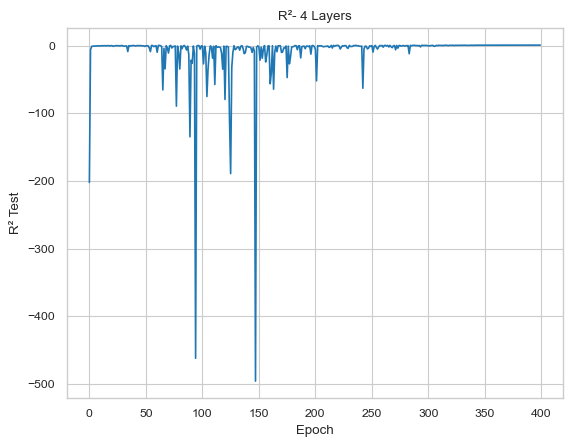

In [22]:
# Graficar el R² del conjunto de prueba al final de cada época
import matplotlib.pyplot as plt
plt.plot( r2_test_values)
plt.xlabel('Epoch')
plt.ylabel('R² Test')
plt.title('R²- 4 Layers')
plt.savefig("R2_4Layers.png", dpi=600)
plt.show()

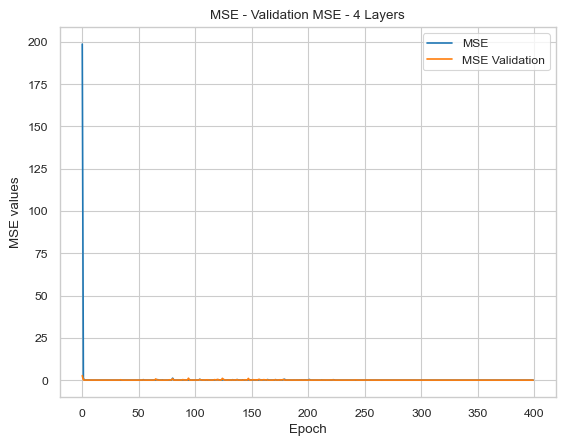

In [29]:
plt.plot(loss_values, label='MSE')
plt.plot(validation_values, label='MSE Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE values')
plt.title('MSE - Validation MSE - 4 Layers')
plt.legend()

plt.savefig("Loss_4Layers.png", dpi=600)
plt.show()

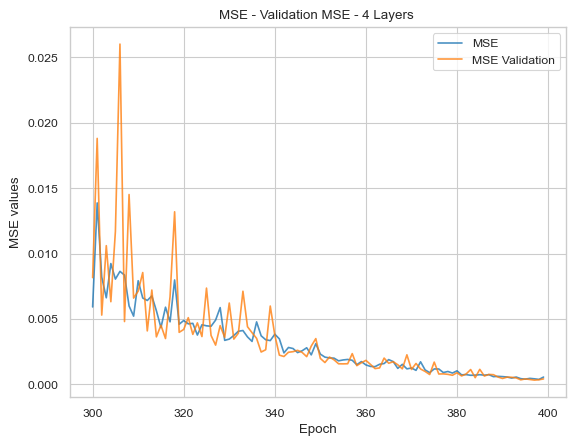

In [28]:
plt.plot(np.arange(300, 400), loss_values[300:], label='MSE', alpha=0.8)
plt.plot(np.arange(300, 400),validation_values[300:], label='MSE Validation',  alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE values')
plt.title('MSE - Validation MSE - 4 Layers ')
plt.legend()

plt.savefig("Loss_4Layers_lastEpochs.png", dpi=600)
plt.show()

In [16]:
save_txt = np.concatenate((x_test_wavelength, y_test, predic), axis=1)
#print(save_txt)
df = pd.DataFrame(save_txt)
df.to_csv("matrixPredi4L.txt", sep=' ', index=False)